In [4]:
import pandas as pd
import numpy as np
import glob, os, subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import palettable
import matplotlib
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# Suppress Matplotlib warnings
warnings.filterwarnings("ignore", category=UserWarning)

matplotlib.rcParams["font.family"] = 'arial'

OUTPUT_DIR = "/data/project/Alzheimer/YSscript/cle/Revision/3.BioData_dissim_signature"
if os.path.exists(OUTPUT_DIR) == False:
    os.system("mkdir -p " + OUTPUT_DIR)

In [362]:
df_total_count  = pd.DataFrame()
decision_dict = {}


DIR = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/3.BioData/Moore_1D/2.woMosaic_ver1"        # AG : 3.woMosaic_ver2
DONOR_LIST = [i.split("/")[-1] for i in sorted(glob.glob(DIR + "/*")) ]
n = 0
n_monoclonal = 0
n_hard = 0
sim_df = pd.DataFrame ( columns = ["DONOR", "TISSUE", "SAMPLENAME", "TISSUE_SAMPLENAME", "CLONE", "COSINE_SIM",  "SBS1_PROPORTION", "SBS1_PERCENTAGE_RAW", "SBS5/40_PROPORTION", "SBS5/40_PERCENTAGE_RAW", "NUM_VARIANT", "TOOL", "DECISION"] )
CLEMENT_mixture_df = pd.DataFrame ( columns = [ "CLEMENT_MIXTURE", "CLONE", "TISSUE_SAMPLENAME" ] )

for DONOR in DONOR_LIST:               # PD42566
    TISSUE_LIST = sorted( glob.glob (DIR + "/" + DONOR + "/*") ) 
    TISSUE_LIST = [i.split("/")[-1] for i in TISSUE_LIST]

    for TISSUE in TISSUE_LIST:               # colon_crypt, pancreas_islet, , "liver_parenchyma"
    #for TISSUE in [ "bronchus_epithelium", "adrenal_gland_zona_glomerulosa",  "adrenal_gland_zona_fasciculata", "thyroid_follicle"]:  
        SAMPLE_LIST = sorted ( glob.glob (DIR + "/" + DONOR + "/" + TISSUE + "/*") ) 
        SAMPLE_LIST = [i.split("/")[-1].split(".")[0] for i in SAMPLE_LIST]

        for SAMPLE in SAMPLE_LIST:       # PD42566b_lo00_A7.txt
            SAMPLENAME = SAMPLE.split("_")[0]
            INPUT_TSV = DIR + "/" + DONOR + "/" + TISSUE + "/" + SAMPLE + ".txt"

            COMBINED_OUTPUT_DIR = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
            NPVAF_DIR = "/data/project/Alzheimer/CLEMENT/02.npvaf/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
            CLEMENT_DIR = "/data/project/Alzheimer/YSscript/cle/data/CLEMENT/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
            # PYCLONEVI_DIR = "/data/project/Alzheimer/YSscript/cle/data/pyclone-vi/3.BioData/Moore_1D/" + TISSUE  + "/" + DONOR + "-" + SAMPLENAME
            # SCICLONE_DIR = "/data/project/Alzheimer/YSscript/cle/data/sciclone/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
            # QUANTUMCLONE_DIR = "/data/project/Alzheimer/YSscript/cle/data/quantumclone/3.BioData/Moore_1D/" + TISSUE  + "/" + DONOR + "-" + SAMPLENAME
            
            # 없다면 (CLEMENT error) 그냥 넘어가자
            if os.path.exists( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt" ) == False:   
                continue
            if not os.path.exists ( CLEMENT_DIR + "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt" ):    # 없다면 (CLEMENT error) 그냥 넘어가자
                continue
            # monoclonal은 집에 가라
            result_df = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt", sep = "\t", header = None, index_col = 0)
            if result_df.loc["NUM_CHILD"][1] == "1":    
                n_monoclonal += 1
                continue



            # Hard, Soft clustering 붙이기
            with open( COMBINED_OUTPUT_DIR  + "/CLEMENT_decision.evidence.txt", 'r') as file:
                decision = "Hard" if "hard" in file.readline().rstrip() else "Soft"
                if decision == "Hard":
                    n_hard +=1
            decision_dict [TISSUE + "_" + SAMPLENAME] = decision

            #print ( "{}\t{}\t{}\t{}".format( DONOR, TISSUE, SAMPLENAME, decision) ) 

            # CLEMENT mixture (VAF) 가져오기
            cc = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.mixture.txt", header = None, sep = "\t")
            cc = cc.iloc[:, 0:cc.shape[1] -1 ].T
            cc.columns = ["CLEMENT_MIXTURE"]
            cc ["CLONE"] = cc.index
            cc ["TISSUE_SAMPLENAME"] = TISSUE + "_" + SAMPLENAME
            CLEMENT_mixture_df = pd.concat ( [CLEMENT_mixture_df, cc], axis = 0)

            # Clone별로 assign 된 mutationn num 가져오기
            dd = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.membership_count.txt", sep = "\t").T
            

            # Signature(SBS) profile 불러오기
            signature_df = pd.read_csv ( CLEMENT_DIR+ "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt", sep = "\t")
            signature_df ["SBS5/40"] = signature_df ["SBS5"] + signature_df ["SBS40"]
            signature_df = signature_df.drop ( ["SBS5", "SBS40"], axis = 1)
            
            ind =  ( np.where( np.array ( signature_df.iloc[ signature_df.shape[0] - 1, :  ]  ) != 0 )[0] )
            signature_df_filtered = signature_df.iloc [:, ind]     # whole이 가지고 있는 SBS만 고른다
            #signature_df_filtered = signature_df.loc[:, (signature_df != 0).any()] # Remove columns with all zeros
            
            # k개 clone + whole의 similarity를 분석
            cosine_sim1 = cosine_similarity(signature_df_filtered.iloc[:, 1:signature_df_filtered.shape[1] ])   
            
            for j in range ( cosine_sim1.shape[1] - 1 ) :    # k개 clone과의 cosine similarity 점수
                cosine_sim = cosine_sim1[cosine_sim1.shape[1] - 1, j]

                if "SBS1" in signature_df_filtered.columns:   # 모든 decomposition에서 SBS1이 없다면 집에 가라
                    sbs1_proportion = round ( signature_df_filtered["SBS1"].iloc[j] / (signature_df_filtered["SBS1"].sum(axis = 0) - signature_df_filtered["SBS1"].iloc[-1]), 2)
                    temp = (signature_df_filtered.iloc[j, 1: ].astype (int))
                    sbs1_percentage_raw = round ( signature_df_filtered["SBS1"].iloc[j] / ( temp.sum(axis = 0)) , 2)
                else:
                    sbs1_proportion = None

                if "SBS5/40" in signature_df_filtered.columns:   # 모든 decomposition에서 SBS5/40이 없다면 집에 가라
                    sbs540_proportion = round ( signature_df_filtered["SBS5/40"].iloc[j] / (signature_df_filtered["SBS5/40"].sum(axis = 0) - signature_df_filtered["SBS5/40"].iloc[-1]), 2)
                    temp = (signature_df_filtered.iloc[j, 1: ].astype (int))
                    sbs540_percentage_raw = round ( signature_df_filtered["SBS5/40"].iloc[j] / ( temp.sum(axis = 0)) , 2)
                else:
                    sbs540_proportion = None


                #print ("j = {}\tn = {}".format( j, dd.iloc[j][0] ) )

                sim_df = sim_df.append ( pd.DataFrame ( [ {"DONOR" : DONOR, "TISSUE" : TISSUE, "SAMPLENAME" : SAMPLENAME, "TISSUE_SAMPLENAME" : TISSUE + "_" + SAMPLENAME , "CLONE" : j, "COSINE_SIM" : cosine_sim, 
                                                           "SBS1_PROPORTION" : sbs1_proportion, "SBS1_PERCENTAGE_RAW" : sbs1_percentage_raw, "SBS5/40_PROPORTION" : sbs540_proportion,  "SBS5/40_PERCENTAGE_RAW" : sbs540_percentage_raw,
                                                            "NUM_VARIANT" : dd.iloc[j][0], 
                                                           "TOOL" : "CLEMENT", "DECISION" : decision } ] ) , ignore_index = True)





SBS1_proportion_df = pd.DataFrame ( sim_df.groupby (["TISSUE_SAMPLENAME"])["SBS1_PROPORTION"].std() ) 
SBS1_proportion_df.columns = ["SBS1_PROPORTION_STD"]
SBS540_proportion_df = pd.DataFrame ( sim_df.groupby (["TISSUE_SAMPLENAME"])["SBS5/40_PROPORTION"].std() ) 
SBS540_proportion_df.columns = ["SBS5/40_PROPORTION_STD"]

total_df = pd.merge ( SBS1_proportion_df, sim_df, left_index = True, right_on = "TISSUE_SAMPLENAME", how = "left").reset_index(drop = True)
total_df = pd.merge ( total_df, SBS540_proportion_df, left_on = "TISSUE_SAMPLENAME", right_on = "TISSUE_SAMPLENAME", how = "left").reset_index(drop = True)


total_df = pd.merge(total_df, CLEMENT_mixture_df, on = ["TISSUE_SAMPLENAME", "CLONE"], how='inner')



j = 0	n = 174
j = 1	n = 182
j = 2	n = 180
j = 0	n = 183
j = 1	n = 180
j = 2	n = 134
j = 3	n = 171
j = 4	n = 156
j = 0	n = 248
j = 1	n = 240
j = 2	n = 291
j = 3	n = 110
j = 0	n = 382
j = 1	n = 164
j = 2	n = 161
j = 3	n = 147
j = 0	n = 309
j = 1	n = 968
j = 0	n = 582
j = 1	n = 915
j = 0	n = 431
j = 1	n = 203
j = 2	n = 239
j = 3	n = 215
j = 0	n = 118
j = 1	n = 144
j = 2	n = 116
j = 3	n = 124
j = 4	n = 107
j = 0	n = 293
j = 1	n = 140
j = 2	n = 134
j = 0	n = 127
j = 1	n = 124
j = 2	n = 122
j = 3	n = 121
j = 0	n = 1394
j = 1	n = 2317
j = 0	n = 1180
j = 1	n = 1460
j = 0	n = 522
j = 1	n = 253
j = 0	n = 659
j = 1	n = 517
j = 0	n = 588
j = 1	n = 195
j = 2	n = 373
j = 0	n = 576
j = 1	n = 578
j = 0	n = 56
j = 1	n = 152
j = 2	n = 142
j = 3	n = 131
j = 4	n = 92
j = 0	n = 767
j = 1	n = 372
j = 0	n = 124
j = 1	n = 211
j = 2	n = 198
j = 0	n = 355
j = 1	n = 906
j = 0	n = 749
j = 1	n = 373
j = 0	n = 1195
j = 1	n = 1168
j = 0	n = 227
j = 1	n = 214
j = 2	n = 175
j = 0	n = 238
j = 1	n = 280
j = 2	n = 255
j 

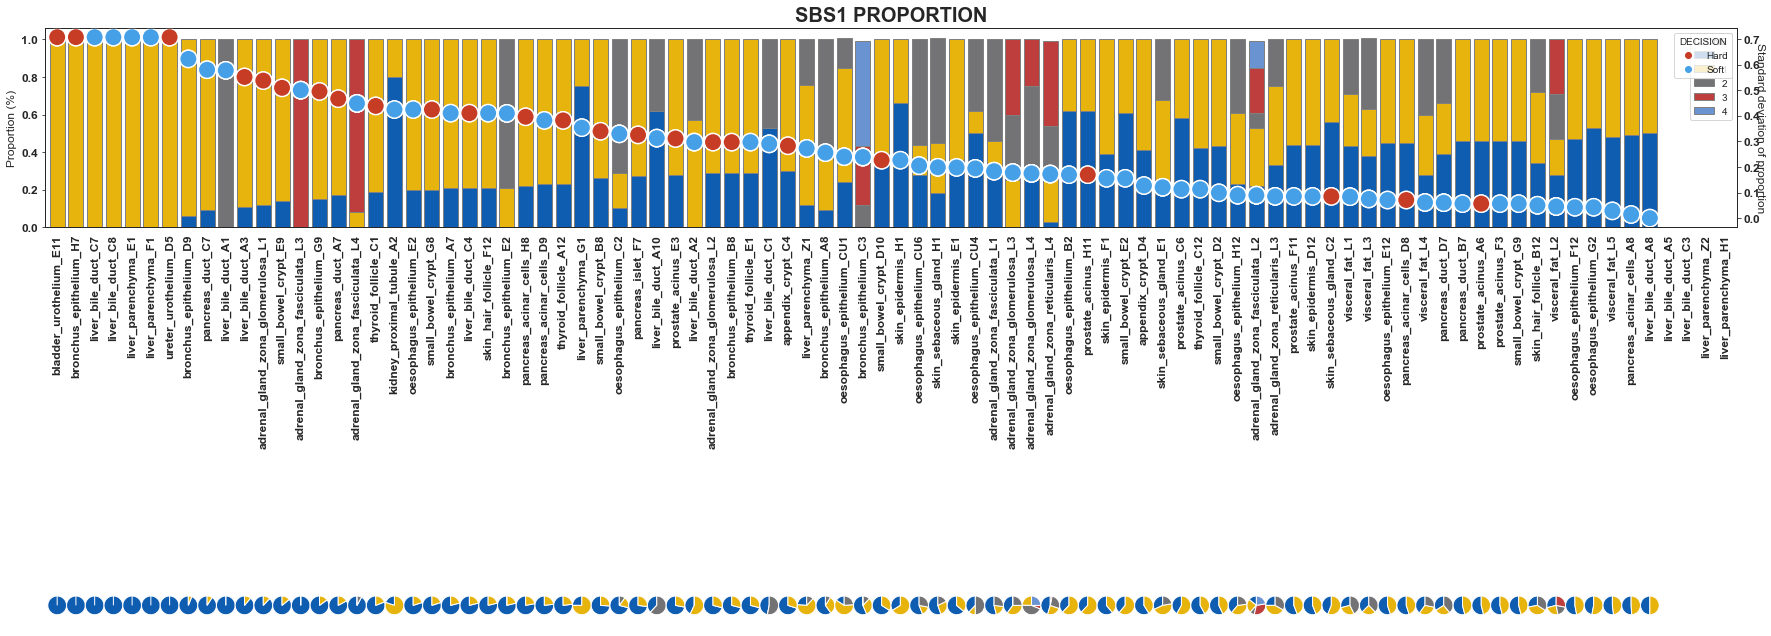

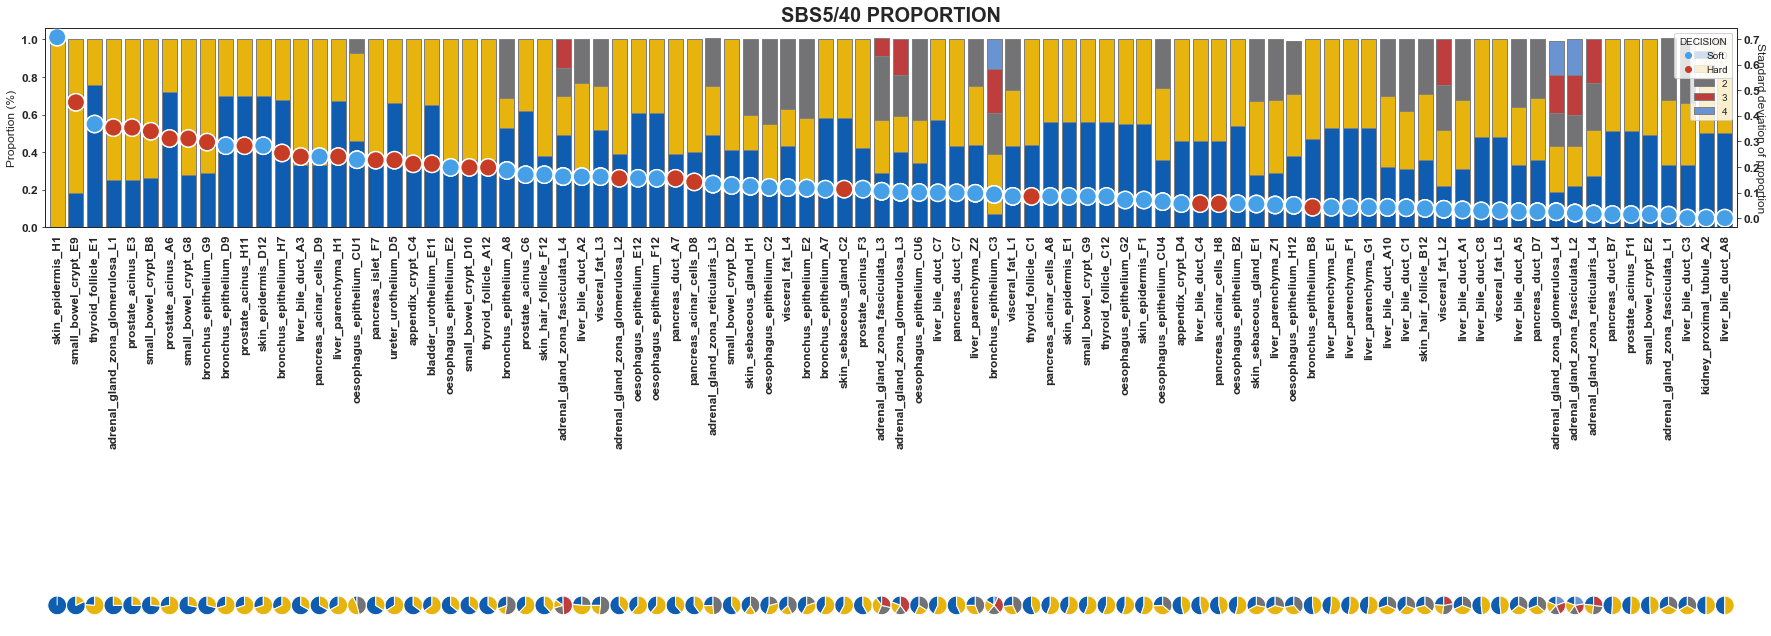

In [363]:
def drawfigure_SBSproportion (total_df, y1, y2, title, OUTPUT_PATH):
    import matplotlib.gridspec as gridspec
    import palettable
    sns.set_style("white")

    tabl = palettable.tableau.Tableau_20.mpl_colors
    safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
    Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
    Antique_10 = palettable.cartocolors.qualitative.Antique_10.mpl_colors
    Accent_8 = palettable.colorbrewer.qualitative.Accent_8.mpl_colors
    colorlist = [i for i in Accent_8]
    colorlist = ["#0F5DB1", "#E7B40E", "#737375", "#BE3E3D", "#6994D1"]

    fig, ax = plt.subplots (nrows = 3, ncols = 1, figsize = (25, 10))
    fig.subplots_adjust ( top = 0.95, bottom = 0.01, left = 0.03, right = 0.97  )
    fig.suptitle ( title , fontsize = 20, y = 0.98, fontweight = "semibold")


    ### ax[0] : xticklabel이 약간 처치곤란이네
    # Stacked bar chart
    ax_twin = ax[0].twinx()
    x_list = []
    for item in total_df["TISSUE_SAMPLENAME"].reset_index(drop = True).tolist():
        if item not in x_list:
            x_list.append(item)
    total_df.loc[:, ["TISSUE_SAMPLENAME", "CLONE", y2 ]].reset_index(drop = True).pivot(index = 'TISSUE_SAMPLENAME', columns='CLONE', values = y2 ).fillna(0).loc[x_list].plot.bar (stacked = True, width = 0.8, ax = ax[0], color = colorlist, edgecolor = "gray")
    ax[0].set_xticklabels ( ax[0].get_xticklabels(), rotation = 90, fontsize = 12, fontweight = "semibold")
    ax[0].set_xlabel (None)
    ax[0].set_yticklabels ( ax[0].get_yticklabels(), fontsize = 12, fontweight = "semibold")
    ax_twin.set_yticks ([])
    ax[0].set_ylabel ( "Proportion (%)", fontsize = 12)

    # scatterplot
    ax_twin = ax[0].twinx()
    sns.scatterplot ( total_df, x = "TISSUE_SAMPLENAME", y = y1, hue = "DECISION", s = 300, palette = {"Hard" : '#C73C25', "Soft" : '#46A0E7' }, ax = ax_twin )
    ax_twin.set_yticks ( np.arange ( min (total_df [y1]), max (total_df [y1]), 0.1))
    ax_twin.set_yticklabels ( ax_twin.get_yticklabels(), fontsize = 12, fontweight = "semibold")
    ax_twin.set_ylabel ( "Standard deviation of proportion", fontsize = 12, rotation = 270)



    ### ax[1] 빈 공간으로 냅두자
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xticks ([])
    ax[1].set_yticks ([])
    ax[1].patch.set_facecolor('none')


    ### ax[2] : Pie chart
    #x_interval = ( ax[0].get_xlim()[1] - ax[0].get_xlim()[0] ) / ( len ( set ( total_df ["TISSUE_SAMPLENAME"] ) )  + 0.5 )
    x_interval = 1
    x = ax[0].get_xlim()[0] + (1 * x_interval)

    # print ( "ax[0].xlim = {}".format ( ax[0].set_xlim() ))
    # print ( "ax[2].ylim = {}".format ( ax[2].set_ylim() ))

    for index, xx in enumerate( ax[0].get_xticklabels() ):         # ax[0]의 xticklabel 순서대로 pie chart를 그린다
        y = 1.0
        xtick = xx.get_text()

        if None in ( list ( total_df[total_df["TISSUE_SAMPLENAME"] == xtick][ y2 ]  ) ):       # SBS1이 아예 없으면 pie chart 몬 만드므로 넘어간다
            # print ( list ( total_df[total_df["TISSUE_SAMPLENAME"] == xtick][ y2 ] ) )
            continue

        ax[2].pie( list ( total_df[total_df["TISSUE_SAMPLENAME"] == xtick][ y2 ] ) , 
                    colors = colorlist, startangle = 90, 
                    #autopct = "%.0f%%",
                    center = (xx.get_position()[0], y), 
                    radius = 0.5) 
        x += x_interval
        #print ("xtick = {}\txx.get_position()[0] = {}\tx = {}".format ( xtick, xx.get_position()[0] , round (x, 2) ))
    ax[2].set_xlim( list (ax[0].get_xlim() ))



    fig.savefig ( OUTPUT_PATH , dpi = 300)
    fig.show()

    return total_df


total_df_SBS1 = drawfigure_SBSproportion ( total_df = total_df.sort_values (by = ["SBS1_PROPORTION_STD", "CLONE"], axis = 0, ascending = False ).reset_index(drop = True), 
                          y1 = "SBS1_PROPORTION_STD",
                          y2 = "SBS1_PROPORTION",
                          title = "SBS1 PROPORTION",
                          OUTPUT_PATH = "/data/project/Alzheimer/YSscript/cle/Revision/3.BioData_dissim_signature/SBS1_proportion_pie.jpg" )

total_df_SBS540 = drawfigure_SBSproportion ( total_df = total_df.sort_values (by = ["SBS5/40_PROPORTION_STD", "CLONE"], axis = 0, ascending = False ).reset_index(drop = True), 
                          y1 = "SBS5/40_PROPORTION_STD",
                          y2 = "SBS5/40_PROPORTION",
                          title = "SBS5/40 PROPORTION",
                          OUTPUT_PATH = "/data/project/Alzheimer/YSscript/cle/Revision/3.BioData_dissim_signature/SBS540_proportion_pie.jpg" )

## VAF - SBS proportion 비율

In [364]:
total_df.sort_values (by = ["SBS1_PERCENTAGE_RAW"], axis = 0, ascending = False )

,SBS1_PROPORTION_STD,DONOR,TISSUE,SAMPLENAME,TISSUE_SAMPLENAME,CLONE,COSINE_SIM,SBS1_PROPORTION,SBS1_PERCENTAGE_RAW,SBS5/40_PROPORTION,SBS5/40_PERCENTAGE_RAW,NUM_VARIANT,TOOL,DECISION,SBS5/40_PROPORTION_STD,CLEMENT_MIXTURE
188,0.098995,PD42565,small_bowel_crypt,D2,small_bowel_crypt_D2,0,0.999952,0.43,0.51,0.41,0.49,1548,CLEMENT,Soft,0.127279,0.50
189,0.098995,PD42565,small_bowel_crypt,D2,small_bowel_crypt_D2,1,0.999221,0.57,0.49,0.59,0.51,2149,CLEMENT,Soft,0.127279,0.68
187,0.226274,PD43850,small_bowel_crypt,D10,small_bowel_crypt_D10,1,0.999929,0.66,0.39,0.64,0.61,1394,CLEMENT,Hard,0.197990,0.62
185,0.339411,PD28690,small_bowel_crypt,B8,small_bowel_crypt_B8,1,0.968976,0.74,0.37,0.74,0.41,2830,CLEMENT,Hard,0.339411,0.73
37,0.282843,PD28690,appendix_crypt,C4,appendix_crypt_C4,1,0.979167,0.7,0.37,0.65,0.63,2317,CLEMENT,Hard,0.212132,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.409186,PD28690,bronchus_epithelium,E2,bronchus_epithelium_E2,0,0.999735,0.0,0.00,0.20,1.00,124,CLEMENT,Soft,0.117189,0.34
96,0.707107,PD43850,liver_parenchyma,F1,liver_parenchyma_F1,1,0.999450,1.0,0.00,0.47,0.79,618,CLEMENT,Soft,0.042426,0.58
28,0.174786,PD28690,adrenal_gland_zona_glomerulosa,L4,adrenal_gland_zona_glomerulosa_L4,4,0.999636,0.0,0.00,0.18,1.00,107,CLEMENT,Soft,0.024900,0.20
98,0.353553,PD43850,liver_parenchyma,G1,liver_parenchyma_G1,1,0.999980,0.25,0.00,0.47,0.78,514,CLEMENT,Soft,0.042426,0.48


In [389]:
import math
np.log10 (total_df["NUM_VARIANT"]) 

0      2.240549
1      2.260071
2      2.255273
3      2.262451
4      2.255273
         ...   
218    2.772322
219    2.588832
220    2.722634
221    2.459392
222    2.487138
Name: NUM_VARIANT, Length: 212, dtype: float64

In [393]:
sorted ( np.log10 (total_df["NUM_VARIANT"]) )

[1.7481880270062005,
 1.9344984512435677,
 1.9637878273455553,
 2.0293837776852097,
 2.041392685158225,
 2.05307844348342,
 2.0644579892269186,
 2.0718820073061255,
 2.0791812460476247,
 2.0827853703164503,
 2.0863598306747484,
 2.093421685162235,
 2.093421685162235,
 2.093421685162235,
 2.103803720955957,
 2.1172712956557644,
 2.123851640967086,
 2.1271047983648077,
 2.1271047983648077,
 2.143014800254095,
 2.143014800254095,
 2.146128035678238,
 2.1522883443830567,
 2.1583624920952498,
 2.164352855784437,
 2.167317334748176,
 2.167317334748176,
 2.167317334748176,
 2.1760912590556813,
 2.1789769472931693,
 2.1818435879447726,
 2.1931245983544616,
 2.1958996524092336,
 2.1986570869544226,
 2.2068258760318495,
 2.2095150145426308,
 2.2121876044039577,
 2.2121876044039577,
 2.214843848047698,
 2.2278867046136734,
 2.232996110392154,
 2.2405492482826,
 2.2430380486862944,
 2.2528530309798933,
 2.255272505103306,
 2.255272505103306,
 2.255272505103306,
 2.2576785748691846,
 2.260071387985

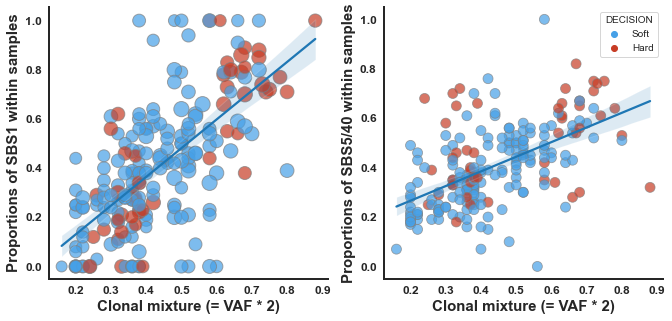

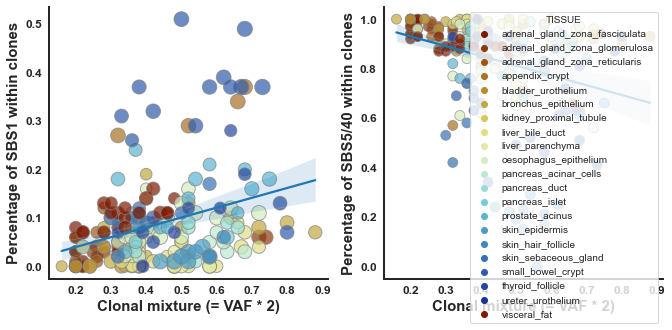

In [399]:
total_df = total_df.astype ({ 'SBS1_PROPORTION':'float', 'SBS1_PERCENTAGE_RAW':'float', 'SBS5/40_PROPORTION':'float', 'SBS5/40_PERCENTAGE_RAW':'float', "NUM_VARIANT":"float" })


def drawfigure_VAF_SBS_correlation (total_df, x, y0, y1, ylabel0, ylabel1, hue, OUTPUT_PATH):
    import palettable, math
    import numpy as np
    if hue == "DECISION":
        palette = {"Hard" : '#C73C25', "Soft" : '#46A0E7' }
    elif hue =="TISSUE":
        Roma_20 = palettable.scientific.diverging.Roma_20.mpl_colors
        palette = [i for i in Roma_20]

    #total_df = total_df[pd.notna(total_df['SBS1_PROPORTION'])]
        

    fig, ax = plt.subplots (nrows = 1, ncols = 2, figsize = (11, 5))
    sns.scatterplot ( total_df , x = x, y = y0, hue = hue, s = np.log (total_df["NUM_VARIANT"]) * 30,  palette = palette,  edgecolor = "gray", alpha = 0.7,  ax = ax[0])
    sns.regplot ( total_df , x = x, y = y0, scatter = False, ci = 95, ax = ax[0])
    #sns.kdeplot(  total_df , x = x, y = y0, levels=5, color="gray", linewidths = 2)
    ax[0].legend_.remove()

    sns.scatterplot ( total_df , x = x, y = y1, hue = hue, s = 100, palette = palette,  edgecolor = "gray", alpha = 0.7,  ax = ax[1])  #, 
    sns.regplot ( total_df , x = x, y = y1, scatter = False, ci = 95, ax = ax[1])
    #sns.kdeplot(  total_df , x = x, y = y1, levels=5, color="gray", linewidths = 2)

    ax[0].set_ylabel ( ylabel0, fontsize = 15, fontweight = "semibold")
    ax[1].set_ylabel ( ylabel1, fontsize = 15, fontweight = "semibold")
    for ax_ind in ax:
        ax_ind.spines['top'].set_visible(False)
        ax_ind.spines['right'].set_visible(False)
        ax_ind.set_xlabel ( "Clonal mixture (= VAF * 2)", fontsize = 15, fontweight = "semibold")
        ax_ind.set_xticklabels ( ax_ind.get_xticklabels(), fontsize = 12, fontweight = "semibold")
        ax_ind.set_yticklabels ( ax_ind.get_yticklabels(), fontsize = 12, fontweight = "semibold")
        for axis in ['left','bottom']:
            ax_ind.spines[axis].set_linewidth(2)

    fig.savefig ( OUTPUT_PATH , dpi = 300)
    fig.show()

drawfigure_VAF_SBS_correlation (total_df, "CLEMENT_MIXTURE", "SBS1_PROPORTION", "SBS5/40_PROPORTION", "Proportions of SBS1 within samples", "Proportions of SBS5/40 within samples" , "DECISION", OUTPUT_PATH = "/data/project/Alzheimer/YSscript/cle/Revision/3.BioData_dissim_signature/SBS1_vaf_proportion_correlation1.jpg")
drawfigure_VAF_SBS_correlation (total_df, "CLEMENT_MIXTURE", "SBS1_PERCENTAGE_RAW", "SBS5/40_PERCENTAGE_RAW", "Percentage of SBS1 within clones", "Percentage of SBS5/40 within clones", "TISSUE", OUTPUT_PATH = "/data/project/Alzheimer/YSscript/cle/Revision/3.BioData_dissim_signature/SBS1_vaf_proportion_correlation2.jpg")

---

In [51]:
### 연습 : cosine_similarity가 참 마음대로 안되네

trial_np = np.array ( [ [21, 471], 
                                [52, 526],
                                 [66, 1088] ])


cosine_sim1 = cosine_similarity( trial_np )   
print (cosine_sim1)

[[1.         0.99854329 0.99987151]
 [0.99854329 1.         0.99927992]
 [0.99987151 0.99927992 1.        ]]
